In [87]:
from cProfile import label

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns



In [88]:
data = pd.read_csv('survey.csv')
data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


## Data preprocessing

### Gender

In [89]:
# Cleaning 'Gender' column from invalid values, assigning mistyped values to correct ones
data['Gender'] = data['Gender'].replace(['M', 'm', 'male', 'Male'], 'Male')
data['Gender'] = data['Gender'].replace(['F', 'f', 'female', 'Female'], 'Female')

data.loc[data['Gender'].str.contains('Fe', case=False), 'Gender'] = 'Female'
female_records = data[data['Gender'].str.contains('Female', case=False)]

other_records = data[~data['Gender'].str.contains('Female', case=False)]
other_records.loc[other_records['Gender'].str.contains('Ma', case=False), 'Gender'] = 'Male'

df = pd.concat([female_records, other_records])

df = df[df['Gender'].isin(['Female','Male'])]

print("Unique Gender values:", df['Gender'].unique())
print("New shape:", df.shape)


Unique Gender values: ['Female' 'Male']
New shape: (1244, 27)


### Age

In [90]:
# Getting rid of invalid values in 'Age' column
df = df[df['Age']<100]
df = df[df['Age']>16]
print("New shape:", df.shape)


New shape: (1239, 27)


## Plots


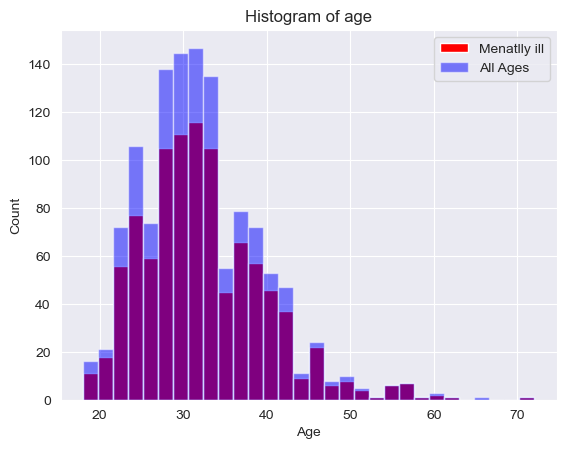

(1239, 27)
(977, 27)


In [91]:
# df_sick == people who have mental health issues
df_sick = df[df['work_interfere'].isna()==False].copy()
plt.hist(df_sick['Age'], bins= 30, color= 'red', label ='Menatlly ill') 
plt.hist(df['Age'], bins=30, alpha=0.5, color='blue', label='All Ages') 
plt.title('Histogram of age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()
print(df.shape)
print(df_sick.shape)

<Axes: xlabel='Gender'>

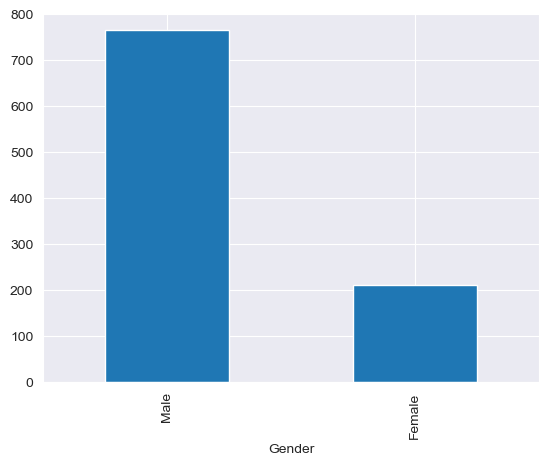

In [92]:
values = df_sick['Gender'].value_counts()
values.plot(kind='bar')

<Axes: title={'center': 'Age'}, ylabel='work_interfere'>

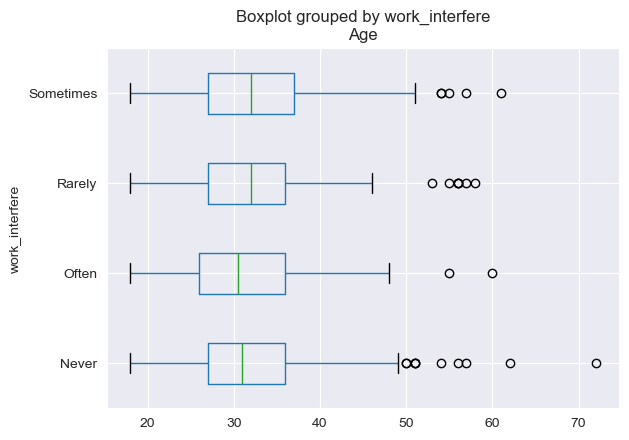

In [93]:
df_sick.boxplot(column = 'Age', by='work_interfere', vert=False)

C:\Users\Bartek\AppData\Local\Temp\ipykernel_11420\1146637642.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_counts = df.groupby('no_employees')['mental_vs_physical'].value_counts().unstack()


Text(0, 0.5, 'Number of answers')

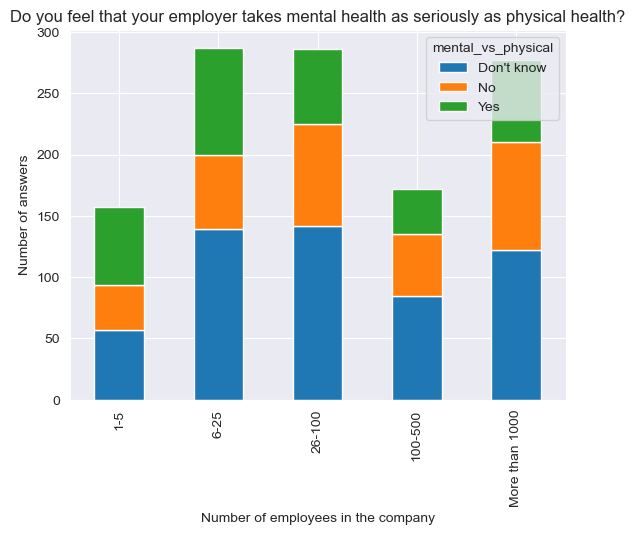

In [94]:
sort_order = ['1-5', '6-25', '26-100', '100-500', 'More than 1000']
df['no_employees'] = pd.Categorical(df['no_employees'], categories=sort_order, ordered=True)
response_counts = df.groupby('no_employees')['mental_vs_physical'].value_counts().unstack()

response_counts.plot(kind='bar', stacked=True)
plt.title('Do you feel that your employer takes mental health as seriously as physical health?')
plt.xlabel('Number of employees in the company')
plt.ylabel('Number of answers')
# No visible correlation

C:\Users\Bartek\AppData\Local\Temp\ipykernel_11420\3528918369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_counts = df.groupby('no_employees')['benefits'].value_counts().unstack()


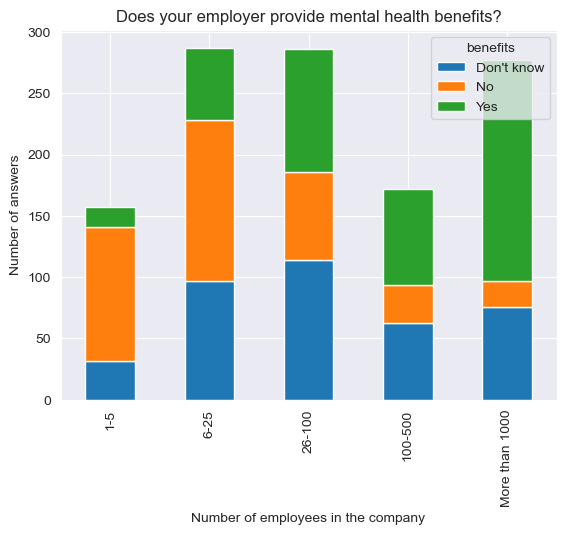

In [95]:
df['no_employees'] = pd.Categorical(df['no_employees'], categories=sort_order, ordered=True)
response_counts = df.groupby('no_employees')['benefits'].value_counts().unstack()
response_counts.plot(kind='bar', stacked=True)
plt.title('Does your employer provide mental health benefits?')
plt.xlabel('Number of employees in the company')
plt.ylabel('Number of answers')
plt.show()
# The bigger the company, the more likely it is to provide mental health benefits


C:\Users\Bartek\AppData\Local\Temp\ipykernel_11420\2608238987.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_counts = df_sick.groupby('work_interfere')['remote_work'].value_counts().unstack()


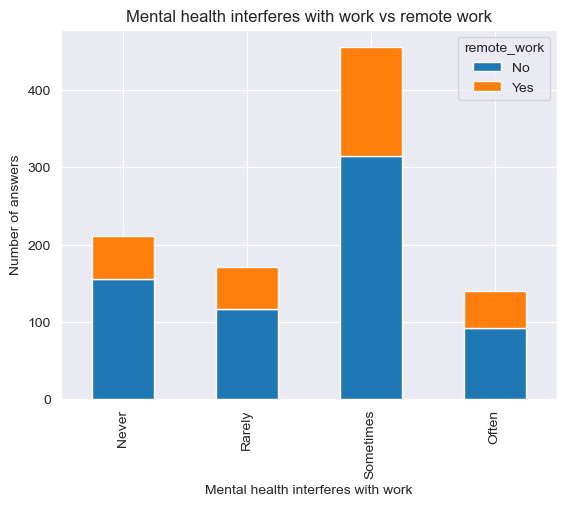

In [96]:
sort_order = ['Never', 'Rarely', 'Sometimes', 'Often']
df_sick['work_interfere'] = pd.Categorical(df_sick['work_interfere'], categories=sort_order, ordered=True)
response_counts = df_sick.groupby('work_interfere')['remote_work'].value_counts().unstack()
response_counts.plot(kind='bar', stacked=True)
plt.title('Mental health interferes with work vs remote work')
plt.xlabel('Mental health interferes with work')
plt.ylabel('Number of answers')
plt.show()
# No visible correlation between remote work and mental health interference

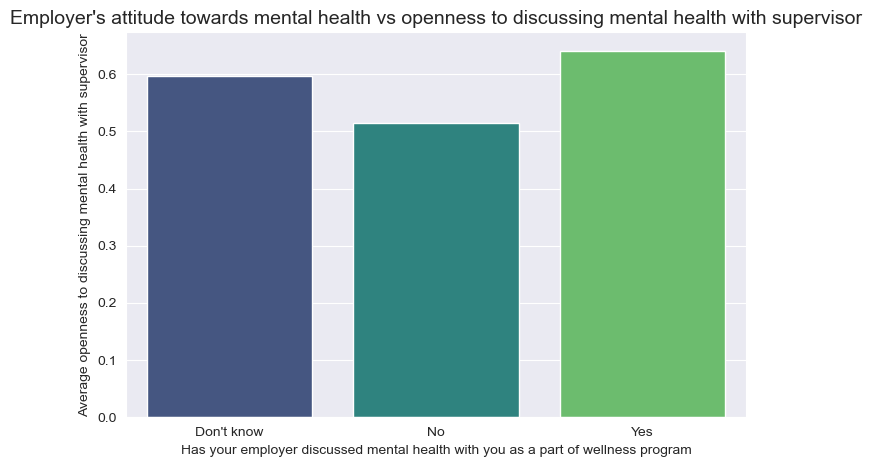

In [97]:
weight_map = {'Yes': 1, 'No': 0, 'Some of them': 0.5}
df['supervisor_weighted'] = df['supervisor'].map(weight_map)
grouped_data = df.groupby('wellness_program')['supervisor_weighted'].mean().reset_index()
grouped_data.columns = ['wellness_program', 'average_supervisor']


plt.figure(figsize=(8, 5))
sns.barplot(data=grouped_data, x='wellness_program', y='average_supervisor', palette='viridis', hue='wellness_program')
plt.title("Employer's attitude towards mental health vs openness to discussing mental health with supervisor", fontsize=14)
plt.xlabel('Has your employer discussed mental health with you as a part of wellness program', fontsize=10)
plt.ylabel('Average openness to discussing mental health with supervisor', fontsize=10)
plt.show()
# Slighlty higher average openness to discussing mental health with supervisor when employer discussed mental health as a part of wellness program

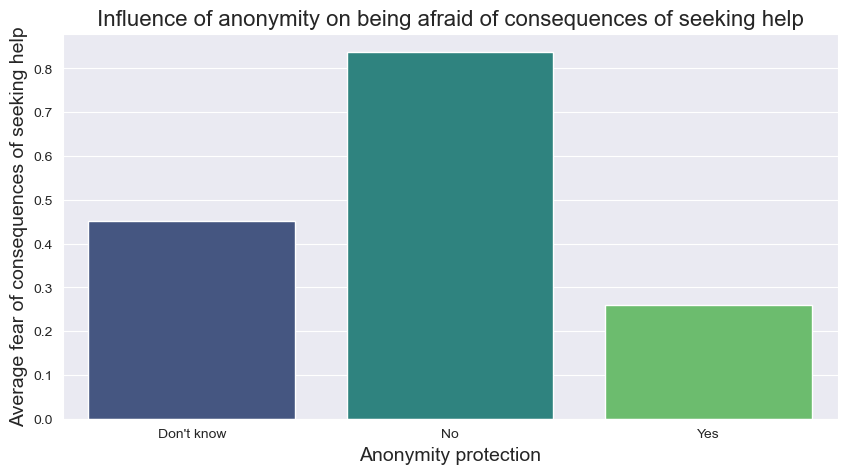

In [102]:
df_sick['mental_health_consequence_weighted'] = df_sick['mental_health_consequence'].map(weight_map)

# Oblicz średnią dla anonimowości
mean_data = df_sick.groupby('anonymity')['mental_health_consequence_weighted'].mean().reset_index()

# Wykres liniowy
plt.figure(figsize=(10, 5))
sns.barplot(data=mean_data, x='anonymity', y='mental_health_consequence_weighted', palette='viridis', hue='anonymity')
plt.title('Influence of anonymity on being afraid of consequences of seeking help', fontsize=16)
plt.xlabel('Anonymity protection', fontsize=14)
plt.ylabel('Average fear of consequences of seeking help', fontsize=14)
plt.show()
# Protection of anonymity has a positive impact on not being afraid of consequences of seeking help, if there is no anonymity protection, the fear is higher

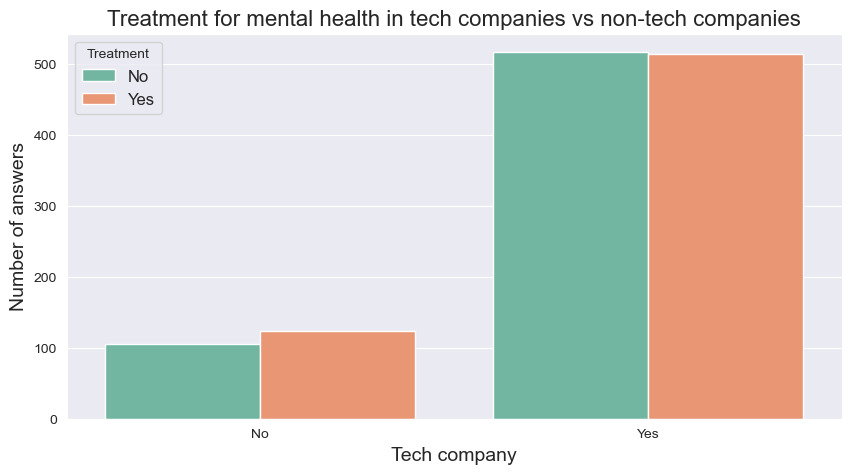

In [105]:
df_sick['treatment_weighted'] = df_sick['treatment'].map(weight_map)

gr_data = data.groupby(['tech_company', 'treatment']).size().reset_index(name='count')

plt.figure(figsize=(10, 5))
sns.barplot(data=gr_data, x='tech_company', y='count', hue='treatment', palette='Set2')
plt.title('Treatment for mental health in tech companies vs non-tech companies', fontsize=16)
plt.xlabel('Tech company', fontsize=14)
plt.ylabel('Number of answers', fontsize=14)
plt.legend(title='Treatment', fontsize=12)

plt.show()

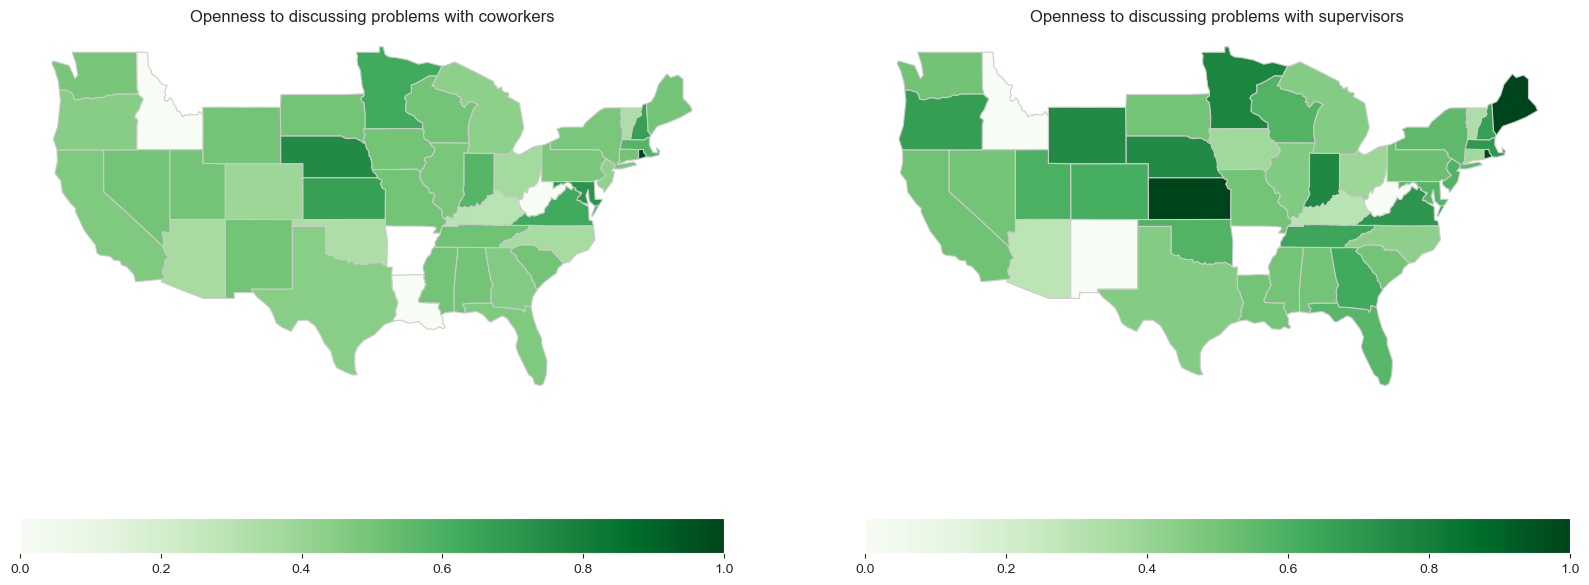

In [110]:

shapefile = 'data/ne_110m_admin_1_states_provinces.shp'

usa_map = gpd.read_file(shapefile)

usa_map['name'] = usa_map['iso_3166_2'].apply(lambda x: x[3:])
data_usa = df[df['Country'] == 'United States'].copy()
data_usa['coworkers_weighted'] = data_usa['coworkers'].map(weight_map)
data_usa['supervisor_weighted'] = data_usa['supervisor'].map(weight_map)

state_coworkers = data_usa.groupby('state')['coworkers_weighted'].mean().reset_index()
state_supervisor = data_usa.groupby('state')['supervisor_weighted'].mean().reset_index()

result = pd.merge(state_coworkers, state_supervisor, left_on='state', right_on='state')
result.columns = ['state', 'coworkers_avg', 'supervisor_avg']

usa_map = usa_map.merge(result, left_on='name', right_on='state')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Map for openness among coworkers
c1 = usa_map.plot(column='coworkers_avg', cmap='Greens', linewidth=0.8, ax=ax[0], edgecolor='0.8')
ax[0].set_title('Openness to discussing problems with coworkers')
ax[0].axis('off')
c1.get_figure().colorbar(c1.collections[0], ax=ax[0], orientation='horizontal')

# Map for openness among supervisors
c2 = usa_map.plot(column='supervisor_avg', cmap='Greens', linewidth=0.8, ax=ax[1], edgecolor='0.8')
ax[1].set_title('Openness to discussing problems with supervisors')
ax[1].axis('off')
c2.get_figure().colorbar(c2.collections[0], ax=ax[1], orientation='horizontal')

plt.show()
# In general, people are more open to discussing problems with supervisors than with coworkers, but there are some states where the situation is reversed

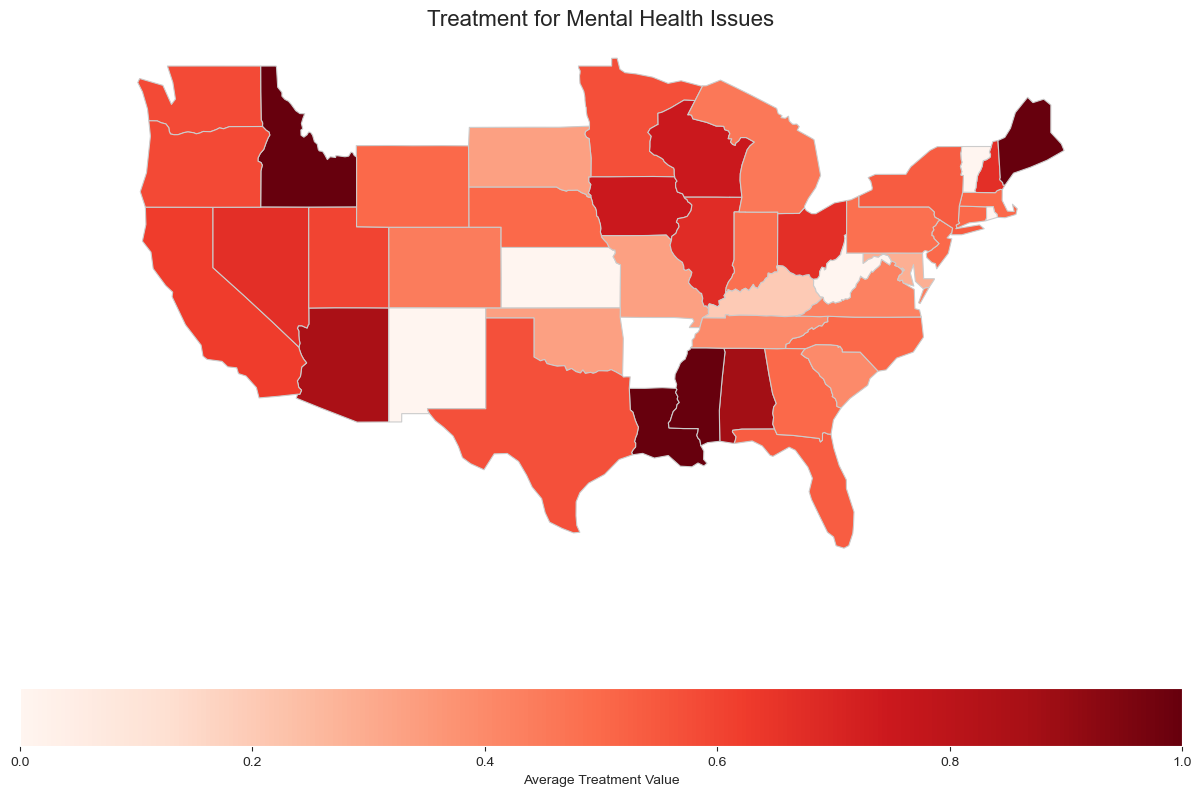

In [78]:
data_usa['treatment_weighted'] = data_usa['treatment'].map(weight_map)

# Calculate average treatment values for each state
state_treatment = data_usa.groupby('state')['treatment_weighted'].mean().reset_index()
usa_map_treatment = usa_map.merge(state_treatment, left_on='name', right_on='state', how='left')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# Map for treatment usage
c = usa_map_treatment.plot(column='treatment_weighted', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Treatment for Mental Health Issues', fontsize=16)
ax.axis('off')
c.get_figure().colorbar(c.collections[0], ax=ax, orientation='horizontal', label='Average Treatment Value')
plt.show()
# There are some states where the treatment usage is higher than in others, but in general, the situation is similar in most states